In [1]:
import sys, os
import scipy.sparse as sps
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

sys.path.append(os.path.abspath('../kernel_inference'))
import new_york_inference as nif
from new_york_inference import load
from mapbox import get_plot, add_rect
from kernel_inference import Bins
from power_iteration import nth_eigen_iter, get_nth_eigens, norm
%matplotlib inline

Load the kernel

In [4]:
kernel = load('../kernel_inference/filtered_paths2.txt')

Get a transition probability matrix corresponding to a time slice of `dt`

In [5]:
def get_matrix(kernel, dt):
    keys = set(kernel.keys())
    for ends in kernel.values():
        keys.update(ends.keys())
    keys = sorted(keys)
    base = 1/float(len(keys))

    mat = []
    for start in keys:
        row = []
        for end in keys:
            row.append(sum(1 for t in kernel[start][end] if t < dt))
        total = float(sum(row))
        mat.append([r / total for r in row] if total > 0 else [base] * len(keys))
    return np.array(mat, np.float64)
        
slice = get_matrix(kernel, 360)
        

In [ ]:
plt.hist(map(np.count_nonzero, slice))
plt.title('Number of non-zero entries in each row of adjacency matrix')
plt.show()

In [ ]:
sc = plt.matshow(slice, cmap=cm.Blues,vmin=0.00001, vmax=1,norm=colors.LogNorm())
plt.colorbar(sc).set_label('Probability')
plt.title('Transition probability matrix')
plt.show()

Find the eigenvalues of the matrix:

In [ ]:
w, v = np.linalg.eig(slice)

In [ ]:
plt.plot(sorted(map(np.abs, w)))
plt.title('Absolute value of eigenvalues')
plt.show()

In [ ]:
sorted(map(np.abs, w))[-10:]

In [ ]:
spec = sps.linalg.svds(slice.T, k=100, return_singular_vectors=False)
plt.plot(spec)

Symmetrize the adjacency matrix $A$:

\frac{A + A^T}{2}

And make sure it is row-stochastic

In [ ]:
symmetric = (slice + slice.T) / 2

Iteratively make the matrix doubly stochastic

In [ ]:
def normalize_rows(matrix):
    return np.array([row / float(sum(row)) for row in matrix])

def iter_norm(mat, n):
    for _ in range(30):
        mat = normalize_rows(mat.T)
    return mat

#print set(round(sum(r),5) for r in slice)
#print set(round(sum(r),5) for r in slice.T)

In [ ]:
spec = sps.linalg.svds(slice, k=1000, return_singular_vectors=False)
plt.plot(spec)

In [ ]:
g = nx.from_numpy_matrix(slice)
lspec = nx.laplacian_spectrum(g)
aspec = nx.adjacency_spectrum(g)

In [ ]:
plt.plot(sorted(aspec))
plt.show()
plt.plot(sorted(lspec))
plt.show()
print lspec[-2]

In [ ]:
plt.plot(np.cumsum(sorted([a**2 for a in aspec])))
plt.show()

In [ ]:
plt.plot(sorted(np.linalg.svd(slice, compute_uv=0)))

In [ ]:
sparse = sps.coo_matrix(symmetric)

In [2]:
spec = sps.linalg.svds(slice, k=1000, return_singular_vectors=False)
plt.plot(spec)

ValueError: need more than 0 values to unpack

Plot the eigenvectors

In [3]:
bins = Bins(nif.MANHATTAN_RECT, nif.BIN_SIZE)
def plot(kernel, fn, minval=0, maxval=1):
    fig, ax = get_plot(nif.MANHATTAN_RECT, figsize=(9, 15))
    for (nx, ny) in kernel:
        add_rect(ax, bins.get_rect(nx, ny), lw=0,
                 alpha=0.5,
                 facecolor=cm.RdYlGn_r(int(fn((nx, ny)) * 255 / maxval)))
    sc = plt.scatter([0], [0], c=[0],cmap=cm.RdYlGn_r, vmin=minval, vmax=maxval)
    plt.colorbar(sc).set_label('Probability')
    return fig, ax

def to_dict(kernel, vec):
    return dict(zip(sorted(kernel.keys()), ev1))

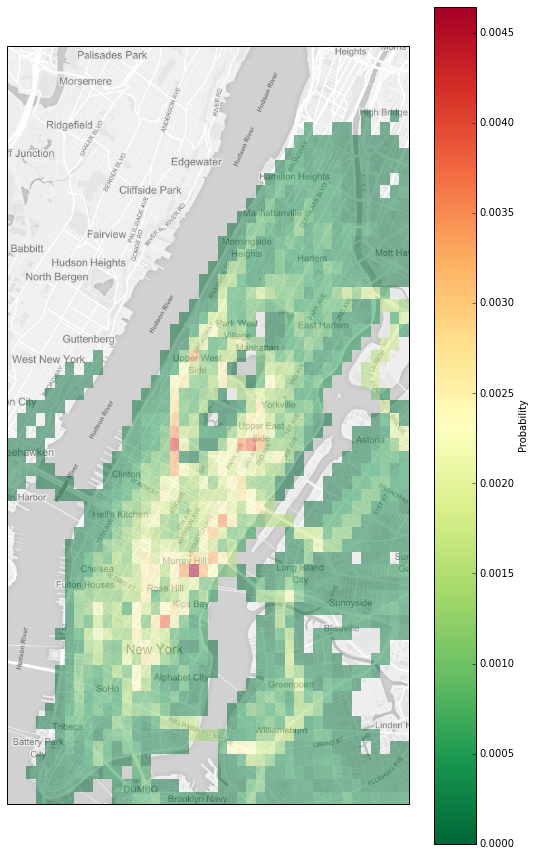

In [6]:
# Get first eigenvector
evl1, ev1 = nth_eigen_iter(slice.T)
ev1 = norm(ev1, 1)
plot(kernel, to_dict(kernel, ev1).get, maxval=max(ev1))
plt.show()

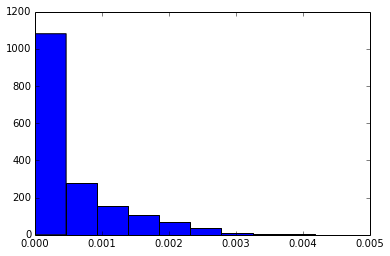

In [7]:
plt.hist(ev1)
plt.show()

In [8]:
# Get second eigenvector
evl2, ev2 = get_nth_eigens(slice.T, 1)

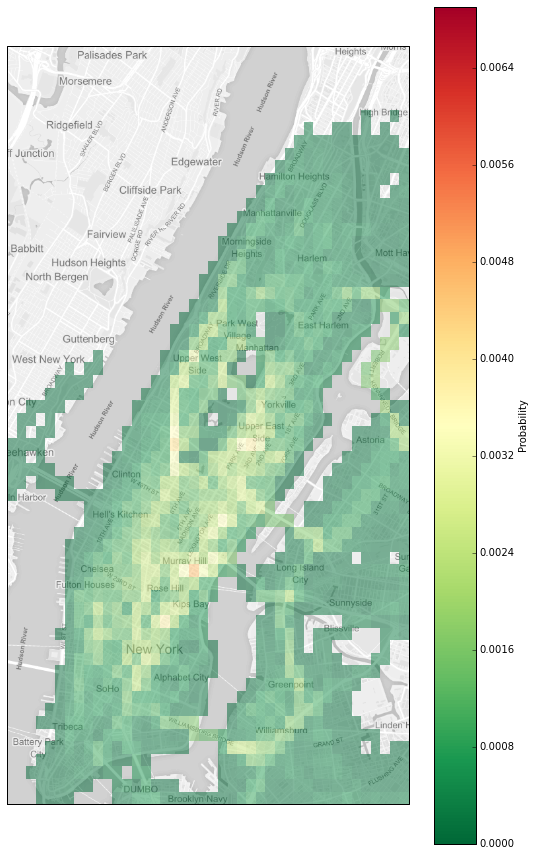

In [14]:
ev2n = np.abs(ev2)
plot(kernel, to_dict(kernel, ev2n).get, minval=min(ev2n), maxval=max(ev2n))
plt.show()

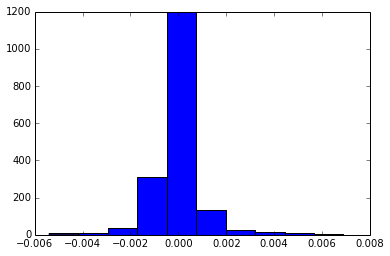

In [13]:
plt.hist(ev2n)
plt.show()